In [1145]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols, wls

In [1146]:
# Target Universe(s): 
#Tech Workers in US ==> compworkers
#Tech Workers in represented states ==> compworkers_sts
#Workers who moved ly ==> moved
#Tech Workers who moved last year ==> compmoved
#Tech Workers who moved from new york last year ==> com




# Dependent Variable(s?) income_total, income_wages
# Independent Variables: state, region, metropolitan_area, 
# age*, education*, occupation_lastyr*, state_lastyr, whymove*
# #NOTE: adjust sample to reduce overcounting of non-head members in household?



In [649]:
raw = pd.read_csv('cps_00009.csv')

In [1147]:
r2016 = raw.loc[raw['YEAR']==2016]
r2017 = raw.loc[raw['YEAR']==2017]
r2018 = raw.loc[raw['YEAR']==2018]


In [1148]:
def raw_column_filter(in_df):
    
    target_cols = ['INCTOT','INCWAGE', 'WKXPNS','OCC','OCCLY','REGION', 'METAREA', 'STATEFIP', 'MIGSTA1', 'AGE', 'SEX',
    'UHRSWORKT','EDUC', 'WHYMOVE', 'ASECWT', 'ASECWTH']
    
    renamed_cols = ['total_income','wage_income','work_expenses','occupation','occupation_ly','region','met_area','state',
                   'state_ly','age','sex','usual_hours_work','education','move_reason','asec_wt','asec_wt_h']
    
    out_df = in_df[target_cols]
    out_df.columns = renamed_cols  
    return out_df


def find_computer_occupations(in_df):
    #TODO: ADD OCCUPATION CODE 0110?
    out_df = in_df[in_df.occupation<=1107]
    out_df = out_df[out_df.occupation>=1000]
    return out_df



def filter_incomes_codes(in_df):
    out_df = in_df[in_df.total_income>0]
    out_df = out_df[out_df.total_income < 9999999]
    out_df = out_df[out_df.wage_income != 0]
    out_df = out_df[out_df.wage_income < 9999999]
    
    return out_df

def filter_hrs_worked(in_df):
    out_df = in_df[in_df.usual_hours_work<500]
    return out_df                     
                                       

def add_normed_incs(in_df):
    cbrt_total_inc = in_df.total_income**(1/3)
    cbrt_wages_inc = in_df.wage_income**(1/3)
    log_total_inc = np.log1p(in_df.total_income)
    log_wages_inc = np.log1p(in_df.wage_income)
    
    return pd.concat([in_df,cbrt_total_inc.rename('cbrt_total'),
                      cbrt_wages_inc.rename('cbrt_wages'),
                      log_total_inc.rename('log_total'),
                      log_wages_inc.rename('log_wages')
                     
                     ], axis=1)


    
    
def get_region_dummies(in_df):
    region_cats = in_df.region.astype('category')
     
    return pd.get_dummies(region_cats, prefix='region')

def get_metro_dummies(in_df):
    metros = in_df.met_area.astype('category')
    return pd.get_dummies(metros,prefix='metro')
    
def get_state_dummies(in_df):
    state_cats = in_df.state.astype('category')
    dummies = pd.get_dummies(state_cats, prefix='state')
    return dummies


# def get_hrs_worked_dummies(in_df):    
#     simple_cats = in_df.usual_hours_work.apply(lambda x: str(x)[0])
#     return pd.get_dummies(simple_cats,prefix='hrscat')


def get_education_dummies(in_df):
    in_df.education = in_df.education.astype('category')
    educ_cats = in_df.education.astype('category')
    dummies = pd.get_dummies(educ_cats, prefix='educ_level')
    return dummies

def get_sex_dummies(in_df):
    in_df.education = in_df.education.astype('category')

    return pd.get_dummies(in_df.sex.astype('category'),prefix='male')

#def get_incom

def get_in_tech_dummies(in_df):
    dummies = in_df.occupation.isin(range(1000,1108)).astype(int).rename('in_tech')
    return dummies
def get_in_tech_ly_dummies(in_df):
    dummies = in_df.occupation_ly.isin(range(1000,1108)).astype(int).rename('in_tech_ly')
    return dummies
#def get_moved_ly()
# def create_state_dummies(in_df):
#     in_df['state' in['06','CA','TX']

def get_tech_vars(in_df):
    tech = get_in_tech_dummies(in_df)
    tech_ly= get_in_tech_ly_dummies(in_df)
    tech_interaction =  tech*tech_ly 

    return pd.concat([tech,tech_ly,tech_interaction.rename('techXtech_ly')],axis=1)

def filter_and_norm(in_df):
    return add_normed_incs(filter_hrs_worked(filter_incomes_codes(in_df)))
    
    

def append_all_dummies(in_df):
    return pd.concat([in_df,get_sex_dummies(in_df).male_1, get_region_dummies(in_df),get_state_dummies(in_df),
                      get_tech_vars(in_df),get_education_dummies(in_df),get_metro_dummies(in_df)],axis=1)
    

In [1289]:
r2016.head()

,YEAR,SERIAL,MONTH,CPSID,ASECFLAG,ASECWTH,REGION,STATEFIP,METAREA,PERNUM,...,UHRSWORKT,UHRSWORK1,EDUC,OCCLY,INDLY,WKXPNS,INCTOT,INCWAGE,MIGSTA1,WHYMOVE
0,2016,2,3,20141202933700,1,1132.05,11,23,9998,1,...,999,0,30,0,0,9999.0,13309,0,99,0
1,2016,7,3,20151202935900,1,1077.54,11,23,9998,1,...,999,0,50,0,0,9999.0,11681,0,99,0
2,2016,7,3,20151202935900,1,1077.54,11,23,9998,2,...,999,0,81,0,0,9999.0,17615,0,99,0
3,2016,8,3,20160202937400,1,1151.49,11,23,9998,1,...,999,0,81,0,0,9999.0,24099,0,99,0
4,2016,9,3,20160102910900,1,705.00,11,23,9998,1,...,999,0,73,9140,6190,1471.0,6300,6000,99,0


/Users/colemiller1/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/colemiller1/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


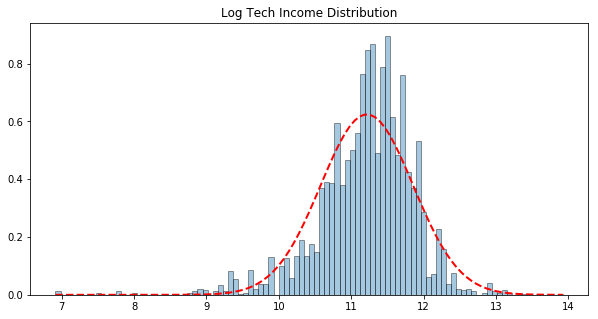

In [1296]:
#normalize total income
import matplotlib.mlab as mlab
# inc_norm = np.log(fullstage['total_income'])
# inc_cube_root = comptest.total_income**(1/3)


# #inc_norm = inc_norm / mu
# #mu = fullstage.total_income.mean()
# # print(mu)
# # Standard distribution

inc_norm = only_tech_2016.log_total
sigma = inc_norm.std()
mu = inc_norm.mean()

num_bins = 100
plt.figure(figsize=(10, 5))
n, bins, patches = plt.hist(inc_norm, num_bins, normed=1, weights=only_tech_2016.asec_wt, edgecolor = 'black', lw = 1,alpha = .40)
y = mlab.normpdf(bins, mu, sigma)
plt.title('Log Tech Income Distribution')
plt.plot(bins, y, 'r--', linewidth=2)

In [1253]:
filtered_2016 = filter_and_norm(raw_column_filter(r2016))
full_2016 = append_all_dummies(filtered_2016)

filtered_2017 = filter_and_norm(raw_column_filter(r2017))
full_2017 = append_all_dummies(filtered_2017)

filtered_2018 = filter_and_norm(raw_column_filter(r2018))
full_2018 = append_all_dummies(filtered_2018)

In [1308]:
data = only_tech_2016

variables = ['age','male_1',
       'usual_hours_work','techXtech_ly',]

met_dumms = data.columns[data.columns.str.startswith('met')][1:]
educ_dumms = data.columns[data.columns.str.startswith('educ_level')][1:]
state_dumms = data.columns[data.columns.str.startswith('state')][2:]


string_vars ="".join([str(var)+"+" for var in X])
add_all_mets = "".join([var+'+' for var in met_dumms])
add_all_educs = ''.join([var+'+' for var in educ_dumms])
add_all_states = ''.join([var+'+' for var in state_dumms])

string_X = string_vars + add_all_educs + add_all_mets
list_X = string_X.split('+')

Y = 'log_total~'



f = Y + string_X 
model = wls(formula='log_total ~ age + male_1 + techXtech_ly + usual_hours_work + C(education) + C(met_area)', data=full_2016, weights = full_2016.asec_wt).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:              log_total   R-squared:                       0.422
Model:                            WLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     190.4
Date:                Sun, 10 Mar 2019   Prob (F-statistic):               0.00
Time:                        12:13:40   Log-Likelihood:                -89926.
No. Observations:               73286   AIC:                         1.804e+05
Df Residuals:                   73005   BIC:                         1.830e+05
Df Model:                         280                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               7.7271      0.120     64.604      0.000       7.493       7.962
C(education)[T.10]     -0.0494      0.084     -0.590      0.555      -0.214       0.115
C(education)[T.20]     -0.0208      0.078     -0.267      0.789      -0.173       0.132
C(education)[T.30]     -0.0264      0.078     -0.337      0.736      -0.180       0.127
C(education)[T.40]     -0.0584      0.078     -0.751      0.453      -0.211       0.094
C(education)[T.50]     -0.1129      0.077     -1.468      0.142      -0.264       0.038
C(education)[T.60]     -0.1382      0.076     -1.822      0.068      -0.287       0.010
C(education)[T.71]      0.0544      0.077      0.703      0.482      -0.097       0.206
C(education)[T.73]      0.3649      0.073      4.966      0.000       0.221       0.509
C(education)[T.81]      0.4779      0.074      6.496      0.000       0.334       0.622
C(education)[T.91]      0.5917      0.074      7.953      0.000       0.446       0.738
C(education)[T.92]      0.6335      0.074      8.550      0.000       0.488       0.779
C(education)[T.111]     0.9015      0.074     12.264      0.000       0.757       1.046
C(education)[T.123]     1.0831      0.074     14.679      0.000       0.938       1.228
C(education)[T.124]     1.3863      0.076     18.147      0.000       1.237       1.536
C(education)[T.125]     1.2492      0.076     16.507      0.000       1.101       1.398
C(met_area)[T.80]       0.2299      0.110      2.100      0.036       0.015       0.445
C(met_area)[T.160]      0.3297      0.109      3.026      0.002       0.116       0.543
C(met_area)[T.200]      0.2096      0.107      1.962      0.050       0.000       0.419
C(met_area)[T.240]      0.2149      0.108      1.991      0.047       0.003       0.426
C(met_area)[T.320]      0.3836      0.132      2.899      0.004       0.124       0.643
C(met_area)[T.440]      0.2448      0.119      2.061      0.039       0.012       0.478
C(met_area)[T.461]      0.2169      0.124      1.749      0.080      -0.026       0.460
C(met_area)[T.462]      0.2636      0.138      1.904      0.057      -0.008       0.535
C(met_area)[T.480]      0.2844      0.121      2.353      0.019       0.047       0.521
C(met_area)[T.501]      0.1799      0.147      1.225      0.221      -0.108       0.468
C(met_area)[T.521]      0.2500      0.096      2.614      0.009       0.063       0.437
C(met_area)[T.560]      0.2143      0.134      1.601      0.109      -0.048       0.477
C(met_area)[T.580]      0.1559      0.124      1.260      0.208      -0.087       0.398
C(met_area)[T.601]      0.1889      0.120      1.573      0.116      -0.046       0.424
C(met_area)[T.641]      0.3195      0.098      3.244      0.001       0.126       0.513
C(met_area)[T.680]      0.3327      0.112      2.965      0.003       0.113       0.553
C(m

In [1309]:
formula = 'log_total ~ C(education) + C(met_area)'
lm = wls(formula, only_tech_2016, weights=only_tech_2016.asec_wt).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df          F        PR(>F)
C(education)  3.307914e+05    12.0  37.974598  2.634978e-80
C(met_area)   2.146823e+05   193.0   1.532354  9.965855e-06
Residual      1.402448e+06  1932.0        NaN           NaN


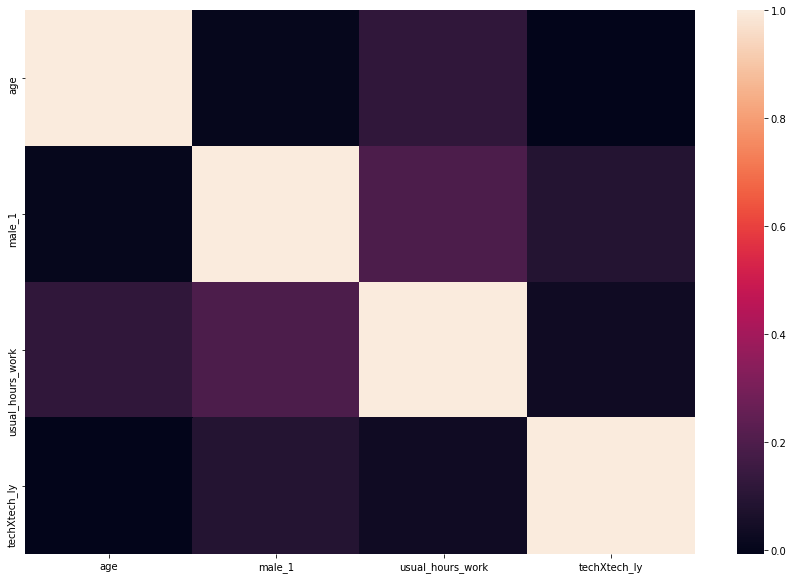

In [1233]:
plt.figure(figsize = (15, 10))
sns.heatmap(full_2016[X].corr())

In [1234]:
only_tech_2016=full_2016[full_2016.in_tech.astype('bool')]
only_tech_2016.education =  only_tech_2016.education.astype(int).astype('category')


only_tech_2017=full_2017[full_2017.in_tech.astype('bool')]
only_tech_2017.education =  only_tech_2017.education.astype(int).astype('category')


only_tech_2018=full_2018[full_2018.in_tech.astype('bool')]
only_tech_2018.education =  only_tech_2018.education.astype(int).astype('category')



/Users/colemiller1/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [1278]:
data = only_tech_2016

X = ['age','male_1',
       'usual_hours_work','techXtech_ly',]

# data =data.drop('met_area',axis=1)
# data = data.drop('education',axis=1)
# data = data.drop('state',axis=1)
    
met_dumms = data.columns[data.columns.str.startswith('met')][1:]
educ_dumms = data.columns[data.columns.str.startswith('educ_level')][1:]
state_dumms = data.columns[data.columns.str.startswith('state')][1:]

formated_X ="".join([str(var)+"+" for var in X])
add_all_mets = "".join([var+'+' for var in met_dumms])
add_all_educs = ''.join([var+'+' for var in educ_dumms])
add_all_states = ''.join([var+'+' for var in state_dumms])

f = 'log_total~'+ formated_X + add_all_educs + add_all_mets

model = wls(formula=f[:-1], data=data, weights = data.asec_wt).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:              log_total   R-squared:                       0.382
Model:                            WLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     5.724
Date:                Fri, 08 Mar 2019   Prob (F-statistic):           2.30e-99
Time:                        13:51:14   Log-Likelihood:                -1855.3
No. Observations:                2137   AIC:                             4129.
Df Residuals:                    1928   BIC:                             5313.
Df Model:                         208                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.9260      0.157     50.643      0.000       7.619       8.233
age                  0.0166      0.001     15.383      0.000       0.015       0.019
male_1               0.1364      0.030      4.513      0.000       0.077       0.196
usual_hours_work     0.0197      0.002     11.062      0.000       0.016       0.023
techXtech_ly         0.5641      0.078      7.187      0.000       0.410       0.718
educ_level_10    -1.326e-14   8.38e-15     -1.582      0.114   -2.97e-14    3.18e-15
educ_level_20        1.6809      0.856      1.963      0.050       0.002       3.360
educ_level_30       -0.6463      1.056     -0.612      0.541      -2.718       1.425
educ_level_40    -2.208e-14   1.62e-14     -1.365      0.172   -5.38e-14    9.64e-15
educ_level_50     4.395e-15   6.27e-15      0.701      0.483    -7.9e-15    1.67e-14
educ_level_60       -0.9579      0.301     -3.180      0.001      -1.549      -0.367
educ_level_71        0.9552      0.534      1.789      0.074      -0.092       2.003
educ_level_73        0.6757      0.130      5.180      0.000       0.420       0.931
educ_level_81        0.7873      0.123      6.376      0.000       0.545       1.029
educ_level_91        0.8090      0.132      6.122      0.000       0.550       1.068
educ_level_92        0.7374      0.129      5.712      0.000       0.484       0.991
educ_level_111       1.0612      0.121      8.805      0.000       0.825       1.298
educ_level_123       1.1618      0.122      9.561      0.000       0.924       1.400
educ_level_124       0.9831      0.184      5.347      0.000       0.622       1.344
educ_level_125       1.0442      0.146      7.171      0.000       0.759       1.330
metro_60          4.373e-16   2.94e-15      0.149      0.882   -5.32e-15    6.19e-15
metro_80            -0.4282      0.223     -1.919      0.055      -0.866       0.009
metro_160            0.1502      0.197      0.761      0.447      -0.237       0.537
metro_200           -0.0431      0.249     -0.173      0.863      -0.532       0.445
metro_240            0.2528      0.219      1.157      0.248      -0.176       0.681
metro_320         8.691e-16   1.58e-15      0.549      0.583   -2.24e-15    3.97e-15
metro_440            0.3161      0.233      1.359      0.174      -0.140       0.772
metro_461         1.194e-15   1.54e-15      0.778      0.437   -1.82e-15     4.2e-15
metro_462        -9.792e-16   1.22e-15     -0.804      0.422   -3.37e-15    1.41e-15
metro_480            0.4243      0.572      0.742      0.458      -0.697       1.546
metro_501        -6.457e-16   1.88e-15     -0.344      0.731   -4.32e-15    3.03e-15
metro_521            0.1050      0.073      1.439      0.150      -0.038       0.248
metro_560            0.4238      0.571      0.743      0.458      -0.695       1.543
metro_580            0.

In [1279]:
model.params.sort_values(ascending=False)

Intercept         7.925954
educ_level_20     1.680877
educ_level_123    1.161809
educ_level_111    1.061157
educ_level_125    1.044248
educ_level_124    0.983128
educ_level_71     0.955194
metro_1305        0.906285
educ_level_91     0.808991
educ_level_81     0.787297
educ_level_92     0.737441
metro_6600        0.725373
educ_level_73     0.675650
metro_1360        0.635646
metro_1530        0.625546
metro_4040        0.597766
metro_2980        0.575029
metro_2670        0.573397
techXtech_ly      0.564128
metro_1661        0.540249
metro_3460        0.533895
metro_1681        0.518933
metro_5220        0.516623
metro_6761        0.511444
metro_3980        0.494963
metro_5170        0.487400
metro_2660        0.480292
metro_8001        0.450454
metro_8731        0.438671
metro_480         0.424343
                    ...   
metro_9321       -0.314122
metro_9997       -0.316183
metro_5482       -0.317685
metro_3122       -0.329478
metro_1020       -0.333942
metro_1010       -0.343952
m

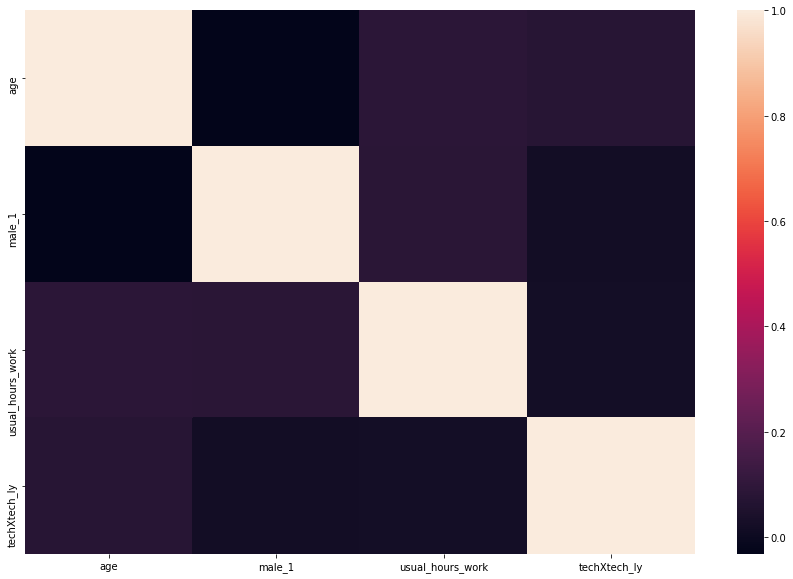

In [1237]:
plt.figure(figsize = (15, 10))
sns.heatmap(only_tech_2016[X].corr())

In [1238]:
full_2016.age.describe()

count    73286.000000
mean        41.882201
std         13.632785
min         15.000000
25%         31.000000
50%         41.000000
75%         52.000000
max         85.000000
Name: age, dtype: float64

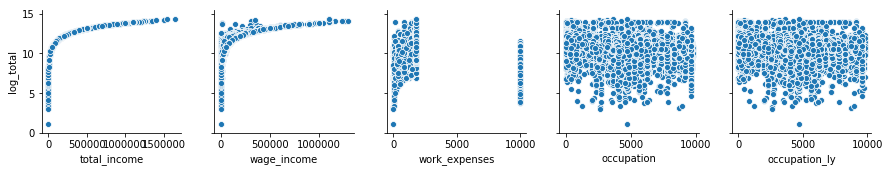

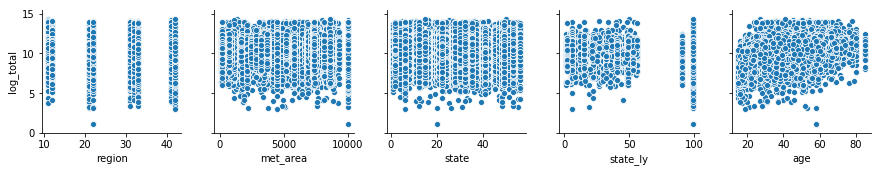

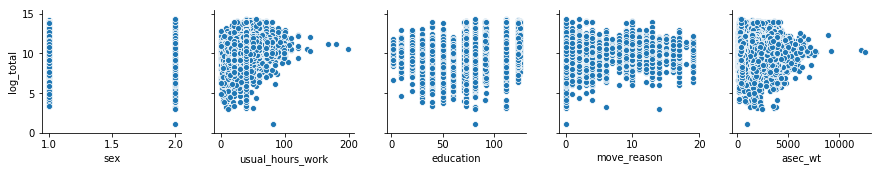

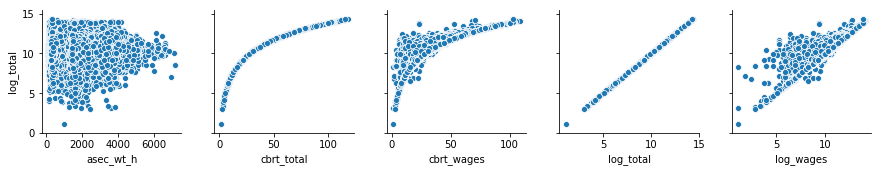

In [1281]:
for i in range(0, len(filtered_2016.columns), 5):
    sns.pairplot(data=filtered_2016,
                x_vars=filtered_2016.columns[i:i+5],
                y_vars=['log_total'])

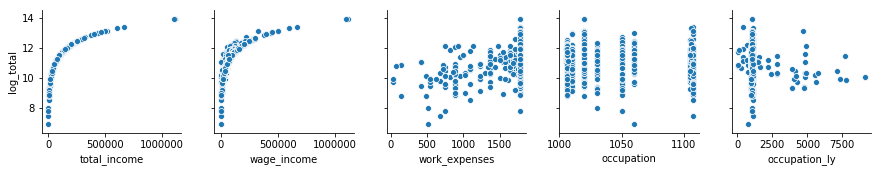

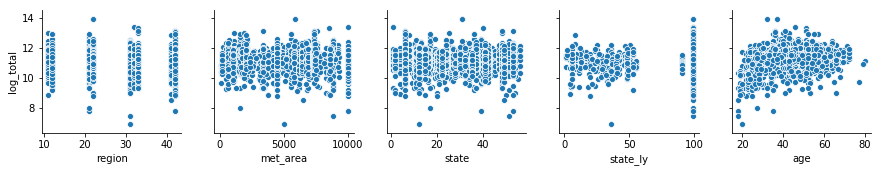

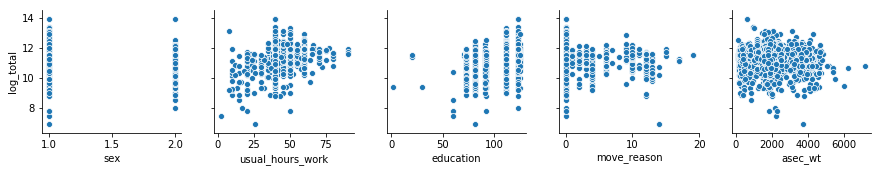

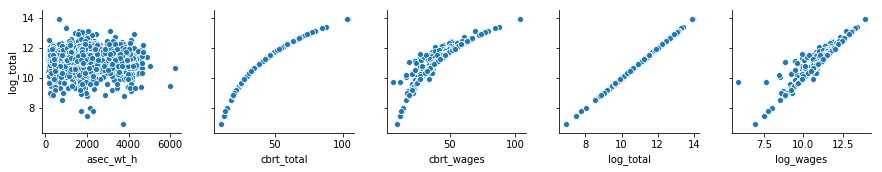

In [1285]:
#small_only_tech_2016=filtered_2016[filtered_2016.in_tech.astype('bool')]

for i in range(0, len(filtered_2016.columns), 5):
    sns.pairplot(data= only_tech_2016,
                x_vars= only_tech_2016.columns[i:i+5],
                y_vars=['log_total'])

In [1144]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x=only_tech_2016.met_area, y=only_tech_2016.log_total)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.title('Tech Income by Metro')
plt.xticks(rotation=45)

AttributeError: 'DataFrame' object has no attribute 'met_area'

<Figure size 720x432 with 0 Axes>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 <a list of 51 Text xticklabel objects>)

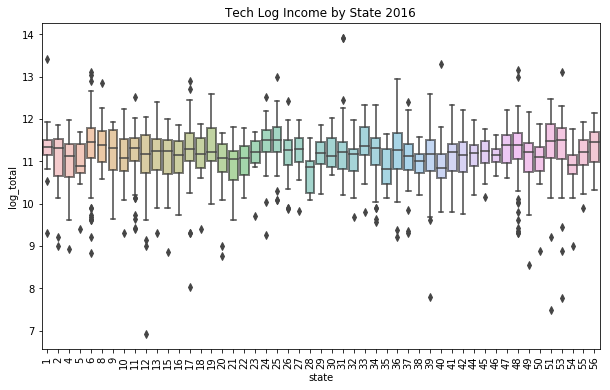

In [1286]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x=only_tech_2016.state, y=only_tech_2016.log_total)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.title('Tech Log Income by State 2016')
plt.xticks(rotation=90)

ValueError: color kwarg must have one color per data set. 362 data sets and 1 colors were provided

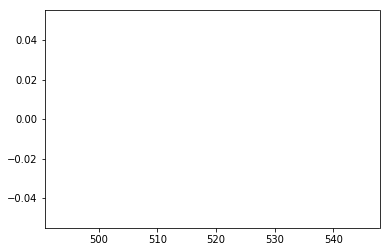

In [1059]:
sns.distplot(only_tech_2016) #all occupation

y=0.011888569390522213x+9.9603985070452


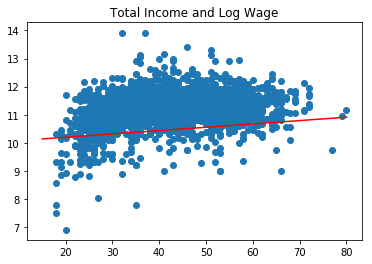

In [1229]:
plt.scatter(only_tech_2016.age, only_tech_2016.log_total)
plt.title('Total Income and Log Wage')

m, b, r, p, std_err = stats.linregress(only_tech_2016.education, only_tech_2016.log_total)
x = np.linspace(15,80,100)
y = m*x+b
plt.plot(x, y, '-r')
print(f'y={m}x+{b}')

#all occupation in NYC area


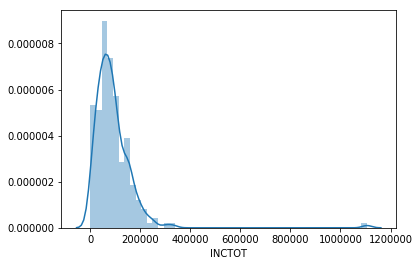

In [253]:
sns.distplot(filt_metro(4484, raw_tech)['INCTOT'])
#tech LA

In [1065]:
overview = raw_filtered.drop(['ASECFLAG', 'SERIAL', 'CPSID', 'ASECWT', 'ASECWTH', 'CPSIDP', 'MONTH', 'SERIAL'], axis =1)

overview.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);


NameError: name 'raw_filtered' is not defined

In [263]:
overview.corr()

,YEAR,REGION,METAREA,PERNUM,AGE,SEX,EDUC,OCCLY,INDLY,WKXPNS,INCTOT,INCWAGE,MIGSTA1,WHYMOVE
YEAR,1.000000,0.005367,-0.004366,0.002214,0.013943,0.000148,0.014556,-0.005368,-0.003442,0.020629,0.021626,0.014953,0.012116,-0.009332
REGION,0.005367,1.000000,0.114869,0.023690,-0.014183,-0.011351,-0.048228,0.009988,-0.010409,0.003281,-0.016688,-0.015832,-0.035103,0.018764
METAREA,-0.004366,0.114869,1.000000,-0.006567,0.027359,-0.003048,-0.053704,0.013330,-0.042955,0.025148,-0.034787,-0.041681,0.003176,-0.004113
PERNUM,0.002214,0.023690,-0.006567,1.000000,-0.289129,0.010242,-0.168227,0.087067,0.028102,0.007381,-0.121965,-0.085382,-0.001545,0.004288
AGE,0.013943,-0.014183,0.027359,-0.289129,1.000000,0.023593,0.033600,-0.294151,-0.328852,0.345768,0.068532,-0.050270,0.161212,-0.133460
SEX,0.000148,-0.011351,-0.003048,0.010242,0.023593,1.000000,0.046191,-0.168242,0.085775,0.090879,-0.164871,-0.141549,0.000320,-0.001604
EDUC,0.014556,-0.048228,-0.053704,-0.168227,0.033600,0.046191,1.000000,-0.175233,0.227699,-0.191168,0.308683,0.282274,-0.011222,0.005335
OCCLY,-0.005368,0.009988,0.013330,0.087067,-0.294151,-0.168242,-0.175233,1.000000,0.344970,-0.599373,-0.016071,0.062739,-0.047035,0.032610
INDLY,-0.003442,-0.010409,-0.042955,0.028102,-0.328852,0.085775,0.227699,0.344970,1.000000,-0.723731,0.163331,0.243955,-0.059481,0.040914
WKXPNS,0.020629,0.003281,0.025148,0.007381,0.345768,0.090879,-0.191168,-0.599373,-0.723731,1.000000,-0.228806,-0.322162,0.068222,-0.046066


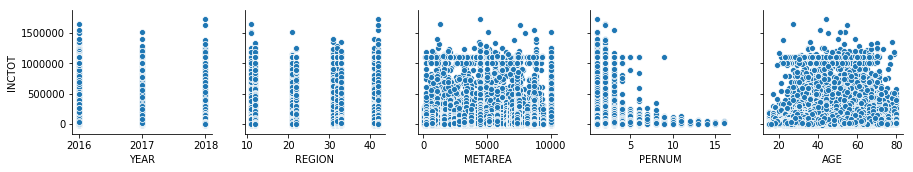

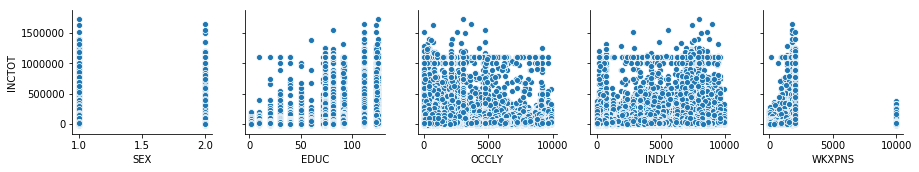

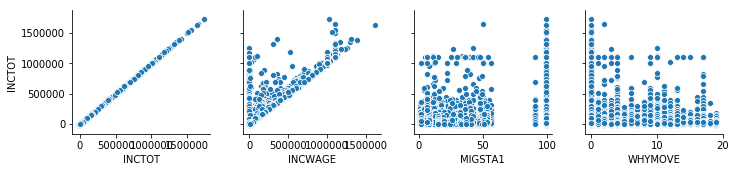

In [264]:
for i in range(0, len(overview.columns), 5):
    sns.pairplot(data=overview,
                x_vars=overview.columns[i:i+5],
                y_vars=['INCTOT'])

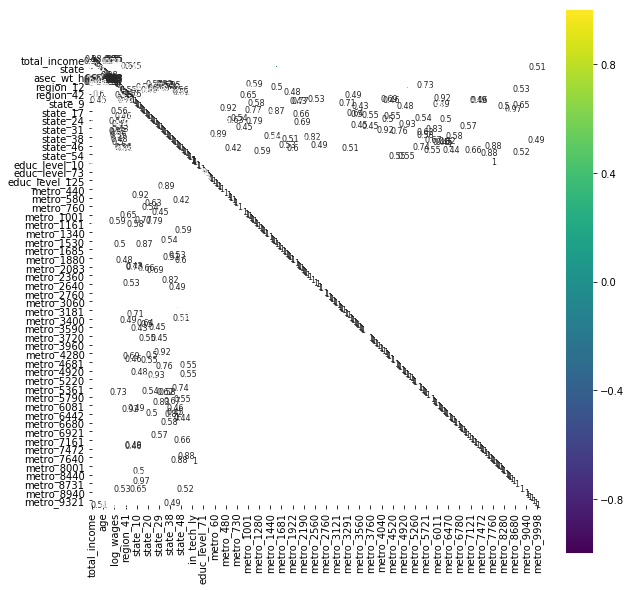

In [1228]:
# corr = only_tech_2016.corr()
# plt.figure(figsize = (10, 10))
# sns.heatmap(corr[(corr >= 0.3) | (corr <= -0.2)], 
#             cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
#             annot=True, annot_kws={"size": 8}, square=True);

In [ ]:
features_to_analyse = [x for x in quantitative_features_list if x in golden_features_list]